In [1]:
import h5py
import json
import random
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback
from wandb.keras import WandbMetricsLogger
import pydicom
sys.path.append('./src')
import numpy as np
#from generators import DataGenerator
from generator_spread import DataGenerator
from models_spread import dota_energies
from preprocessing import DataRescaler
from preprocessing_hamdi import get_scaling_factors
from tensorflow_addons.optimizers import LAMB
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.config import list_physical_devices
import json
import tensorflow as tf
from evaluation_hamdi import metrics
from evaluation_hamdi import calculate_metrics

print(list_physical_devices('GPU'))

2024-03-23 16:43:21.497534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 16:43:21.671314: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 16:43:22.612073: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-23 16:43:22.612147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [3]:
gpu_index = 0
gpus = tf.config.experimental.list_physical_devices('GPU')
print('Available GPUs: ', gpus)
mem_growth = tf.config.experimental.get_memory_growth(gpus[gpu_index])
print('Memory growth: ', mem_growth)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[gpu_index], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpu_index], True)
    mem_growth = tf.config.experimental.get_memory_growth(gpus[gpu_index])
    print('GPU set to be visible and memory growth set to: ', mem_growth)

Available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
Memory growth:  None
GPU set to be visible and memory growth set to:  True


In [6]:
with open('hyperparameters_mps.json', 'r') as hfile:
    param = json.load(hfile)


path = r"/tudelft.net/staff-umbrella/simelectrons/OneGeometryMultipleEnergyMultipleSpread"
test_df=pd.read_pickle(os.path.join(path,'test_picklefile.pkl'))

testIDs=test_df['cropped_geometry_name'].tolist()
path_weights = os.path.join(os.path.dirname(path),'weights_mpe_mps/ckpt/weights.ckpt')

with open('scale_mpe_mps.json', 'r') as file:
    scale_json = file.read()
scale = json.loads(scale_json)

transformer = dota_energies(
    num_tokens=param['num_tokens'],
    input_shape=param['data_shape'],
    projection_dim=param['projection_dim'],
    num_heads=param['num_heads'],
    num_transformers=param['num_transformers'], 
    kernel_size=param['kernel_size'],
    causal=True
)

# Load weights from checkpoint.
transformer.load_weights(path_weights)

(151,)
(None, 151, 3468)


In [2]:
path = r"/tudelft.net/staff-umbrella/simelectrons/OneGeometryMultipleEnergyMultipleSpread"
test_df=pd.read_pickle(os.path.join(path,'test_picklefile.pkl'))

testIDs=test_df['cropped_geometry_name'].tolist()
    
with open('scale_mpe_mps.json', 'r') as file:
    scale_json = file.read()
scale = json.loads(scale_json)

def infer(model,path, filename, scale, ikey='GeometryAll', okey='DoseAll',df=test_df):
    """
    Get model prediction from test sample ID.
    """
    


    geometry_path=os.path.join(path,ikey,filename+'.dcm')
    tmp_geometry=np.swapaxes(pydicom.dcmread(geometry_path).pixel_array,0,2)
    geometry = np.expand_dims(tmp_geometry, axis=(0,-1))
    
    inputs = (geometry - scale['x_min']) / (scale['x_max'] - scale['x_min'])
    ground_truth_filename=df[df['cropped_geometry_name']==filename]['cropped_dose_name'].iloc[0]+'.dcm'
    ground_truth_metadata=pydicom.dcmread(os.path.join(path,okey,ground_truth_filename))
    ground_truth_array=ground_truth_metadata.pixel_array*ground_truth_metadata.DoseGridScaling
    ground_truth= np.swapaxes(ground_truth_array,0,2)
    
    energy_temp = df[df['cropped_geometry_name']==filename]['energy'].iloc[0]
    energy=(energy_temp - scale['e_min']) / (scale['e_max'] - scale['e_min'])
    spread_temp=df[df['cropped_geometry_name']==filename]['beam_spread'].iloc[0]
    spread=(spread_temp - scale['s_min']) / (scale['s_max'] - scale['s_min'])

    
    energies_spread_combined = np.array([[energy, spread]])

    
    # Predict dose distribution
    prediction = model.predict([inputs, energies_spread_combined],verbose=None)
    prediction = prediction * (scale['y_max']-scale['y_min']) + scale['y_min']

    return np.squeeze(geometry), np.squeeze(prediction), np.squeeze(ground_truth)






In [3]:
df=calculate_metrics.main(testIDs,path=path)

100%|██████████| 5134/5134 [05:22<00:00, 15.93it/s]


In [5]:
test_df=pd.read_pickle(os.path.join(path,'test_picklefile.pkl'))

In [6]:
complete_data=test_df.merge(df, on='cropped_geometry_name',how='left')

In [8]:
%store complete_data

Stored 'complete_data' (DataFrame)


In [1]:
complete_data

NameError: name 'complete_data' is not defined

In [4]:

def plot_slice(inputs, ground_truth, outputs, dose_threshold=1,
    distance_threshold=3, cutoff=0, figsize=(10,12), fontsize=10,
    resolution=[2,2,2], gamma_slice=False, savefig=False):
    """
    Plots slices of the full beam along the Z axis.
    *inputs..........3D array [Y,X,Z] from function infer
    """
    # Initialize figure and axes.
    fig, axs = plt.subplots(5, 1, figsize=figsize)
    axs[0].set_title("CT scan", fontsize=fontsize, fontweight='bold')
    axs[1].set_title("Target (MC)", fontsize=fontsize, fontweight='bold')
    axs[2].set_title("Predicted (model)", fontsize=fontsize, fontweight='bold')
    
    plt.subplots_adjust(hspace=0.675, wspace=0.0675)


    ground_truth[ground_truth<(cutoff/100)*scale['y_max']] = 0
    outputs[outputs<(cutoff/100)*scale['y_max']] = 0

    ground_truth=ground_truth* (1e9 / 1e5)
    outputs=outputs* (1e9 / 1e5)
    
    # Cut off MC noise

    

    # Calculate maximum and minimum per column.
    min_input, max_input = np.min(inputs), np.max(inputs)
    min_output, max_output = np.min(outputs), np.max(outputs)
    min_ground_truth, max_ground_truth = np.min(ground_truth), np.max(ground_truth)
    slice_number = int(np.floor(ground_truth.shape[-1]/2))
    cb_ticks=np.linspace(0, max_output, num=4)
    # 1st row: input values
    cbh0 = axs[0].imshow(np.transpose(inputs[:,:,slice_number]), aspect='auto',
        cmap='gray', vmin=min_input, vmax=max_input)
    plt.sca(axs[0])
    plt.yticks([68,34,1], ['2','34','68'], fontsize=fontsize)
    plt.xticks([25, 50, 75, 100, 125, 150], ['50', '100', '150', '200', '250', '300'], fontsize=fontsize)
    axs[0].set_ylabel("mm", loc='top', fontsize=fontsize)
    axs[0].set_xlabel("mm", loc='right', fontsize=fontsize)
    cb0 = fig.colorbar(cbh0, ax=axs[0], aspect=fontsize)
    cb0.ax.set_ylabel("HU", size=fontsize)
    cb0.ax.tick_params(labelsize=fontsize)

    # 2nd row: ground truth
    axs[1].imshow(np.transpose(inputs[:,:,slice_number]), aspect='auto',
        cmap='gray', alpha=0.4, vmin=min_input, vmax=max_input)
    cbh1 = axs[1].imshow(np.transpose(ground_truth[:,:,slice_number]), aspect='auto',
        cmap='turbo', alpha=0.6, vmin=min_output, vmax=max_output)
    plt.sca(axs[1])
    plt.yticks([68,34,1], ['2','34','68'], fontsize=fontsize)
    plt.xticks([25, 50, 75, 100, 125, 150], ['50', '100', '150', '200', '250', '300'], fontsize=fontsize)
    axs[1].set_ylabel("mm", loc='top', fontsize=fontsize)
    axs[1].set_xlabel("mm", loc='right', fontsize=fontsize)
    cb1 = fig.colorbar(cbh1, ax=axs[1], aspect=fontsize,ticks=cb_ticks)
    cb1.ax.set_ylabel(r"Gy/$10^9$ particles", size=fontsize)
    cb1.ax.tick_params(labelsize=fontsize)

    # 3rd row: model prediction
    axs[2].imshow(np.transpose(inputs[:,:,slice_number]), aspect='auto',
        cmap='gray', alpha=0.4, vmin=min_input, vmax=max_input)
    cbh2 = axs[2].imshow(np.transpose(outputs[:,:,slice_number]), aspect='auto', 
        cmap='turbo', alpha=0.6, vmin=min_output, vmax=max_output)
    plt.sca(axs[2])
    plt.yticks([68,34,1], ['2','34','68'], fontsize=fontsize)
    plt.xticks([25, 50, 75, 100, 125, 150], ['50', '100', '150', '200', '250', '300'], fontsize=fontsize)
    axs[2].set_ylabel("mm", loc='top', fontsize=fontsize)
    axs[2].set_xlabel("mm", loc='right', fontsize=fontsize)
    cb2 = fig.colorbar(cbh2, ax=axs[2], aspect=fontsize, ticks=cb_ticks)
    cb2.ax.set_ylabel(r"Gy/$10^9$ particles", size=fontsize)
    cb2.ax.tick_params(labelsize=fontsize)

    # 4th row: difference or gamma analysis results
    if gamma_slice:
        axes = (np.arange(ground_truth.shape[0])*resolution[0],
            np.arange(ground_truth.shape[1])*resolution[1],
            np.arange(ground_truth.shape[2])*resolution[2])
        gamma_values = np.nan_to_num(
            gamma(axes, ground_truth, axes, outputs, dose_threshold,
            distance_threshold, lower_percent_dose_cutoff=0.1, quiet=True), 0)
        axs[3].imshow(np.transpose(inputs[:,:,slice_number]), aspect='auto',
            cmap='gray', alpha=0.4, vmin=min_input, vmax=max_input)
        cbh3 = axs[3].imshow(np.transpose(np.absolute(gamma_values[:,:,slice_number])),
            aspect='auto', alpha=0.6, vmin=0, vmax=2, cmap='RdBu')

    else:
        axs[3].imshow(np.transpose(inputs[:,:,slice_number]), aspect='auto',
            cmap='gray', alpha=0.4, vmin=min_input, vmax=max_input)
        difference=np.transpose(np.absolute(ground_truth[:,:,slice_number]-outputs[:,:,slice_number]))
        cbh3 = axs[3].imshow(difference,
            aspect='auto', cmap='turbo', alpha=0.6, vmin=min_output, vmax=max_output)
        
    plt.sca(axs[3])
    plt.yticks([68,34,1], ['2','34','68'], fontsize=fontsize)
    plt.xticks([25, 50, 75, 100, 125, 150], ['50', '100', '150', '200', '250', '300'], fontsize=fontsize)
    axs[3].set_ylabel("mm", loc='top', fontsize=fontsize)
    axs[3].set_xlabel("mm", loc='right', fontsize=fontsize)
    cb3 = fig.colorbar(cbh3, ax=axs[3], aspect=fontsize,ticks=cb_ticks)

    if gamma_slice:
        axs[3].set_title("Gamma analysis", fontsize=fontsize, fontweight='bold')
    else:
        axs[3].set_title("Dose difference max={}".format(np.max(np.round(difference,2))), fontsize=fontsize, fontweight='bold')
    if gamma_slice:
        cb3.ax.set_ylabel(r"$\gamma$ value", size=fontsize)
    else:
        cb3.ax.set_ylabel(r"Gy/$10^9$ particles", size=fontsize)
    cb3.ax.tick_params(labelsize=fontsize)

    axs[4].imshow(np.transpose(inputs[:,:,slice_number]), aspect='auto',
            cmap='gray', alpha=0.4)

    
    
    relative_error = difference*100/max_ground_truth
    ticks_relative_error=np.linspace(0, np.max(relative_error), num=4)
   
    cbh4 = axs[4].imshow(relative_error, aspect='auto', cmap='turbo', alpha=0.6, vmin=0, vmax=np.max(relative_error))
    axs[4].set_title(f"Relative Error: {np.round(np.mean(relative_error[relative_error>0]),2)} %", fontsize=fontsize, fontweight='bold')
    cb4 = fig.colorbar(cbh4, ax=axs[4], aspect=fontsize,ticks=ticks_relative_error)
    cb4.ax.set_ylabel(r"%", size=fontsize)
    cb4.ax.tick_params(labelsize=fontsize)
    plt.sca(axs[4])
    plt.yticks([68,34,1], ['2','34','68'], fontsize=fontsize)
    plt.xticks([25, 50, 75, 100, 125, 150], ['50', '100', '150', '200', '250', '300'], fontsize=fontsize)
    if savefig:
        plt.savefig(time.strftime('%Y%m%d-%H%M'), dpi=300, bbox_inches='tight') 

    plt.show()






In [43]:
idx=1

filename=df['names'].values[idx]

print(test_df[test_df['cropped_geometry_name']==filename]['energy'].iloc[0])
print(test_df[test_df['cropped_geometry_name']==filename]['beam_spread'].iloc[0])

path = r"/tudelft.net/staff-umbrella/simelectrons/OneGeometryMultipleEnergyMultipleSpread"

prediction = np.load(os.path.join(path, 'Prediction', filename + '.npy'))
ground_truth = np.load(os.path.join(path, 'GroundTruth', filename + '.npy'))
geometry = np.load(os.path.join(path, 'Geometry', filename + '.npy'))


print(masked_relative_error(ground_truth,prediction))

390.47689986109356
0.4553873128696929
nan


370.75439176073087
0.20752433137455115
gamma pass rate 10% : 96.368 %
relative error 0.1% : 2.144 %
RMSE Errorr 0.1% mask: 0.001993159383890516 Gy


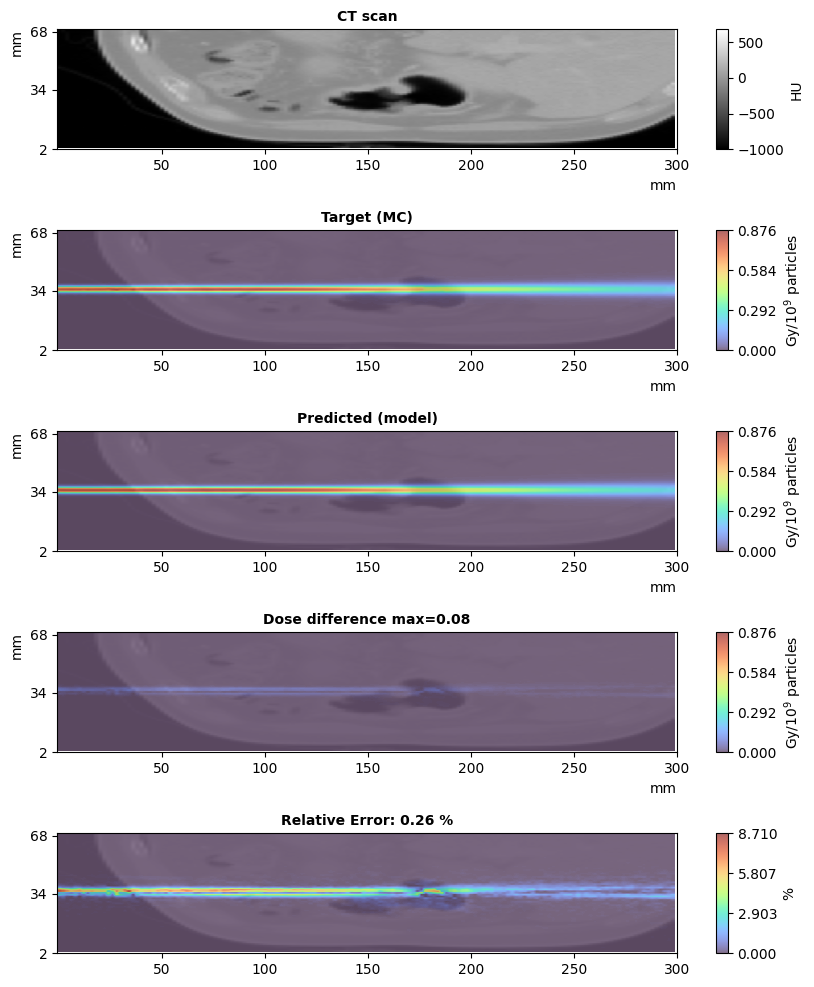

In [61]:
idx=np.random.randint(0,len(testIDs))

filename=df['names'].values[idx]

print(test_df[test_df['cropped_geometry_name']==filename]['energy'].iloc[0])
print(test_df[test_df['cropped_geometry_name']==filename]['beam_spread'].iloc[0])

path = r"/tudelft.net/staff-umbrella/simelectrons/OneGeometryMultipleEnergyMultipleSpread"

prediction = np.load(os.path.join(path, 'Prediction', filename + '.npy'))
ground_truth = np.load(os.path.join(path, 'GroundTruth', filename + '.npy'))
geometry = np.load(os.path.join(path, 'Geometry', filename + '.npy'))
print(f"gamma pass rate 10% : {gamma_analysis(ground_truth, prediction, 10)} %")
#print(f"gamma pass rate 5% : {gamma_analysis(ground_truth, prediction, 5)} %")
#print(f"gamma pass rate 3% : {gamma_analysis(ground_truth, prediction, 3)} %")
print(f"relative error 0.1% : {masked_relative_error(ground_truth, prediction, 0.1)} %")
print(f"RMSE Errorr 0.1% mask: {masked_RMSE(ground_truth, prediction, 0.1)} Gy")
plot_slice(geometry, ground_truth, prediction)


In [35]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [41]:
dose_difference=np.abs(ground_truth-prediction)
equal=dose_difference[dose_difference==0]
print(len(equal)/np.prod(ground_truth.shape))

0.9958910034602076


In [29]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

# Assuming test_df and other necessary variables like transformer and scale are defined
testIDs = test_df['cropped_geometry_name'].tolist()

# Define the base path for saving the outputs
base_path = r"/tudelft.net/staff-umbrella/simelectrons/OneGeometryMultipleEnergyMultipleSpread"

# Folders for geometry, prediction, and ground truth
geometry_path = os.path.join(base_path, "Geometry")
prediction_path = os.path.join(base_path, "Prediction")
ground_truth_path = os.path.join(base_path, "GroundTruth")

# Ensure the directories exist
for directory in [geometry_path, prediction_path, ground_truth_path]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Loop through all IDs in testIDs
for idx in tqdm(range(len(testIDs))):
    # Generate a random index - If you truly need a random sample each time, else just use idx
    
    filename = testIDs[idx]

    # Print energy and beam spread for this index

    # Call the inference function
    geometry, prediction, ground_truth = infer(transformer, path, filename, scale)

    # Construct file paths
    geometry_file_path = os.path.join(geometry_path, f"{filename}.npy")
    prediction_file_path = os.path.join(prediction_path, f"{filename}.npy")
    ground_truth_file_path = os.path.join(ground_truth_path, f"{filename}.npy")

    # Save the numpy arrays
    np.save(geometry_file_path, geometry)
    np.save(prediction_file_path, prediction)
    np.save(ground_truth_file_path, ground_truth)


100%|██████████| 5134/5134 [53:47<00:00,  1.59it/s] 


In [9]:
RMSEs=df['RMSE'].tolist()
relative_errors=df['relative_error'].tolist()

def find_indices(arr):
    sorted_indices = np.argsort(arr)
    lowest_index = sorted_indices[0]
    highest_index = sorted_indices[-1]
    median_index = sorted_indices[len(arr) // 2]
    return lowest_index, highest_index, median_index

lowest_relative_error, highest_relative_error, median_relative_error = find_indices(np.array(relative_errors))
lowest_RMSE, highest_RMSE, median_RMSE = find_indices(np.array(RMSEs))

print(lowest_relative_error, highest_relative_error, median_relative_error)
print(lowest_RMSE, highest_RMSE, median_RMSE)


660 1216 1067
4900 898 116
